In [1]:
import urllib.request, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import warnings

QC = "https://kustom.radio-canada.ca/coronavirus/canada_quebec"

REGIONS = [
    'montreal',
    'laval',
    'monteregie',
    'laurentides',
    'lanaudiere',
    'outaouais',
    'capitale-nationale',
    
    'nunavik',
    'nord-du-quebec',
    'abitibi-temiscamingue',
    'estrie',
    'mauricie-centre-du-quebec',
    'chaudiere-appalaches',
    'bas-saint-laurent',
    'gaspesie-iles-de-la-madeleine',
    'cote-nord',
    'saguenay-lac-saint-jean'
]

In [2]:
# Data Settings
LAST_DAYS = 150
NTH_LABEL = 10
MA_WINDOW = 3

# Plot Settings
# plt.style.use('dark_background')
%matplotlib inline

# Notebook settings
warnings.filterwarnings('ignore')

In [3]:
def plot(df, Region=None, Hospitalizations=False, ICU=False, Change=False, MA=False, Deaths=False, Tests=False, Annotate=True):
    fig = plt.figure(figsize = (15,10))
    
    if (Hospitalizations and 'H' in df):
        plt.plot(df['H'], label="Hosp. (incl. ICU)")
    
    if (ICU and 'I' in df):
        plt.plot(df['I'], label="ICU")
    
    if (Change):
        plt.plot(df['Change'], label="Change")
        
    if (MA):
        plt.plot(df['MA'], label="%s DMA (People)" % MA_WINDOW)
        
    if (Deaths):
        plt.plot(df['D'], label="Deaths (Total)")
    
    if (Tests):
        plt.plot(df['T'], label="Tests Conducted (Millions)")
    
    plt.title(Region.title())
    plt.xlabel("Days (last %s ending %s)" % (LAST_DAYS, np.datetime_as_string(df.tail(1)['Date'], unit='D')[0]))
    plt.ylabel("Active Cases" if not Tests else "Tests (millions)")
    
    plt.grid(True)

    if (Annotate):
        for i, row in df.iterrows():
            if i % NTH_LABEL == 0 or i == df.index[-1]:
                if (ICU):
                    plt.annotate(str(row['I']), (i, row['I']))

                if (Hospitalizations):
                    plt.annotate(str(row['H']), (i, row['H']))

                if (MA):
                    plt.annotate(str(row['Active']), (i, row['MA']))
                    plt.annotate(str(row['Change']), (i, row['Change']))

    plt.legend(loc='upper left')
    plt.show()

def get(r=None):
    with urllib.request.urlopen("%s_%s" % (QC, r) if r is not None else QC) as response:
        data = json.load(response)[0]['History']
        df = pd.json_normalize(data)

        # Cast types
        df['Date'] = pd.to_datetime(df['Date'])
        numeric_cols = ['C', 'D', 'H', 'I', 'R', 'T']
        df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

        # MA calculations make more sense with "today" at the end
        df = df[::-1]
        df.set_index('Date')

        df['Active'] = df.C - df.R - df.D
        df['Change'] = np.round(df['Active'].diff(), decimals=0)

        df = df.sort_values(by=['Date'], ignore_index=True)

        df['MA'] = df['Active'].rolling(window=MA_WINDOW).mean()

        # Last N days
        df = df.tail(LAST_DAYS)
        
        return df

# Notes

* The following charts are updated at "interesting intervals" (see age at the top, generally daily).
* More populous regions appear near the top.
* The `x DMA` is the x-day (configurable) Daily Moving Average of *active cases* (new - recoveries - deaths).
* `Change` is for the x-day DMA.
* "Quebec" refers to the province as a whole (which is the only jurisdiction that reports Hospitalisations and ICU admissions).

# Data Window

The data window has been updated to show the evolution of the entire pandemic in order to compare the Second Wave with the First Wave.

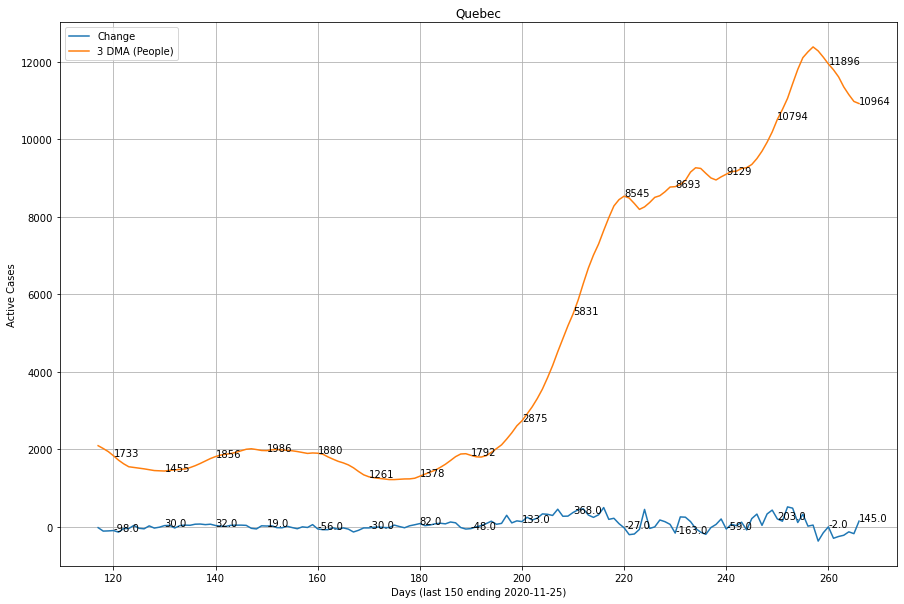

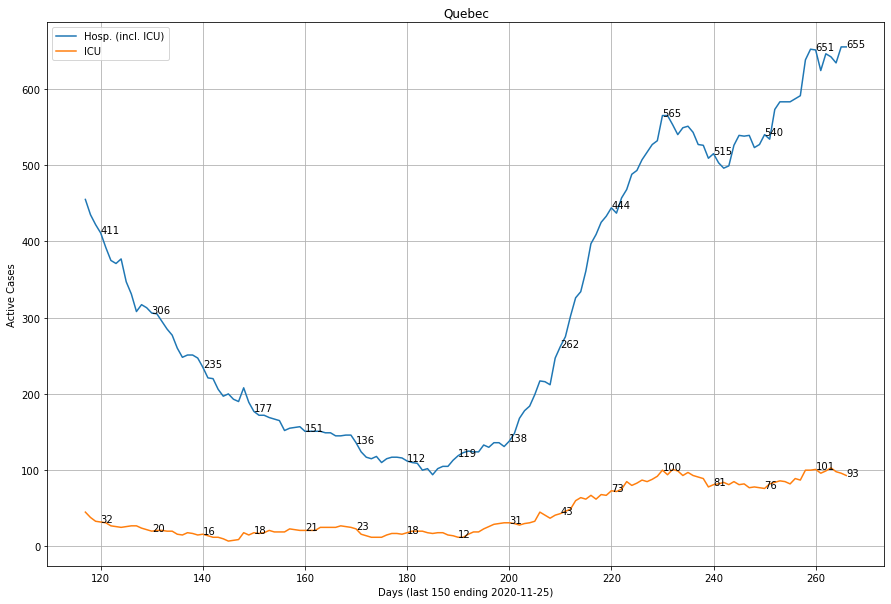

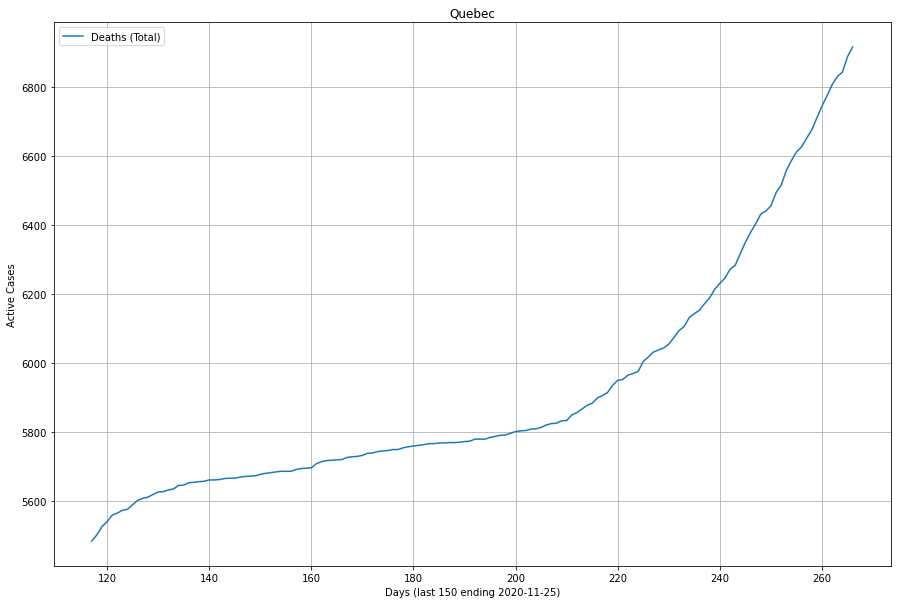

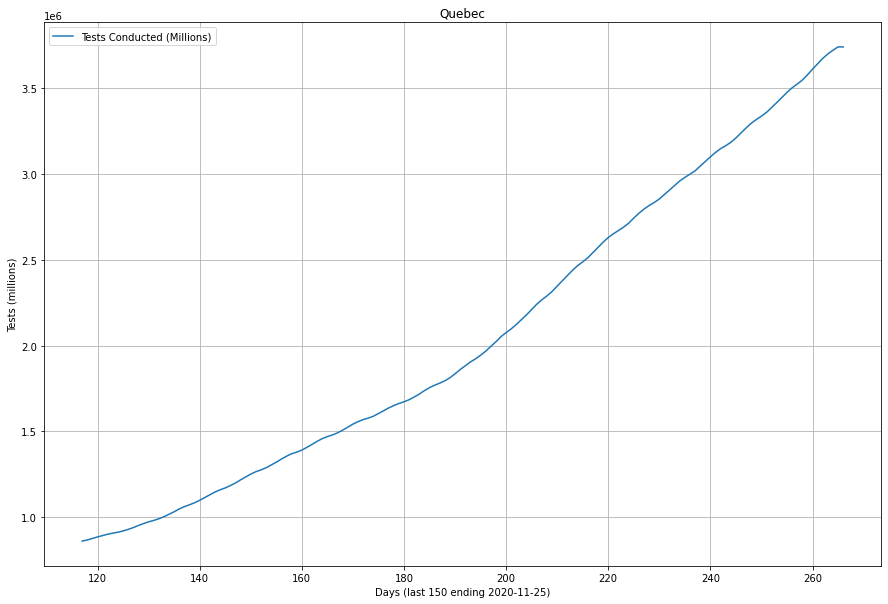

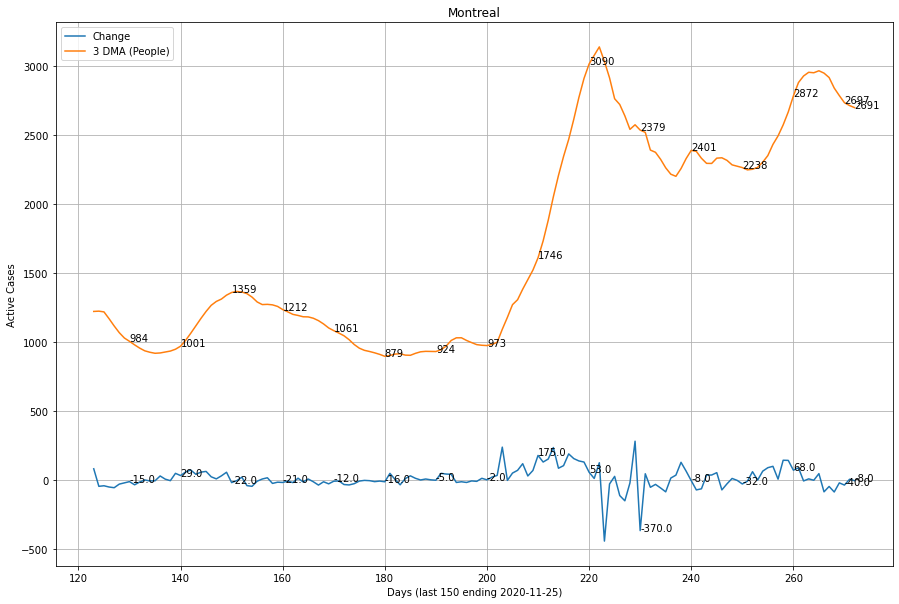

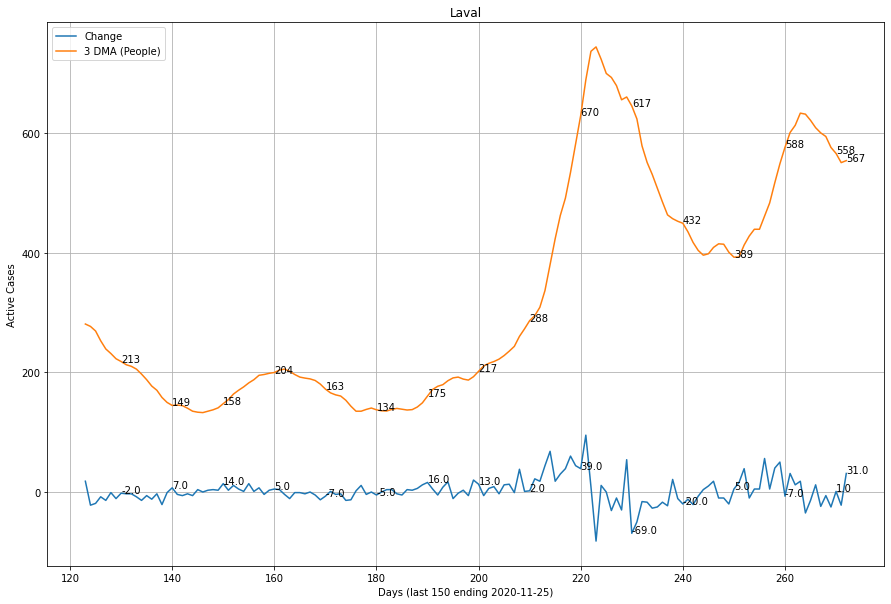

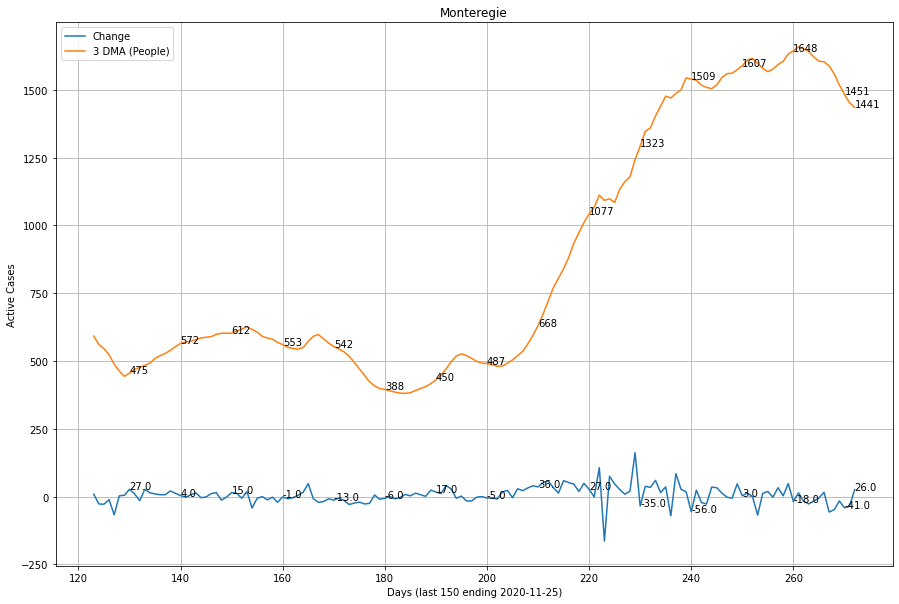

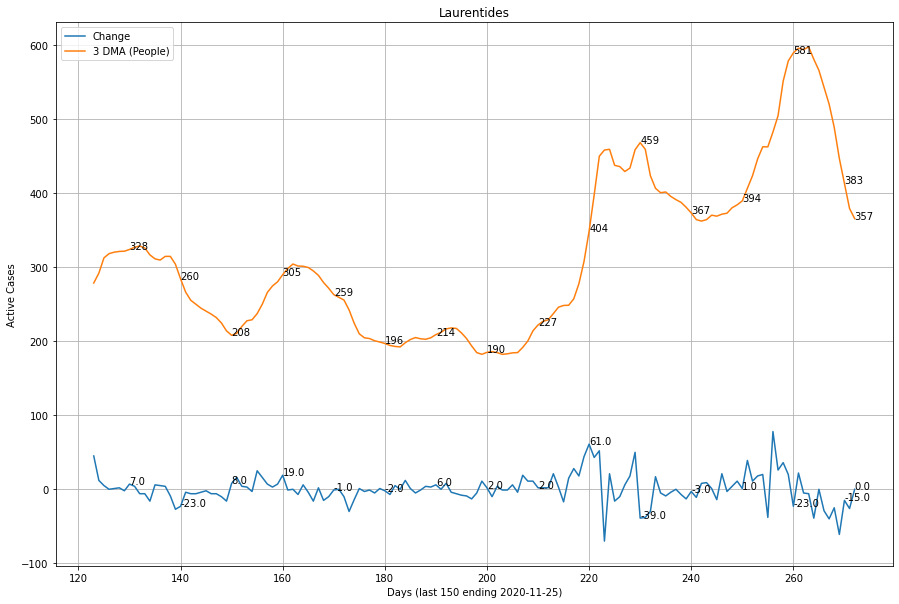

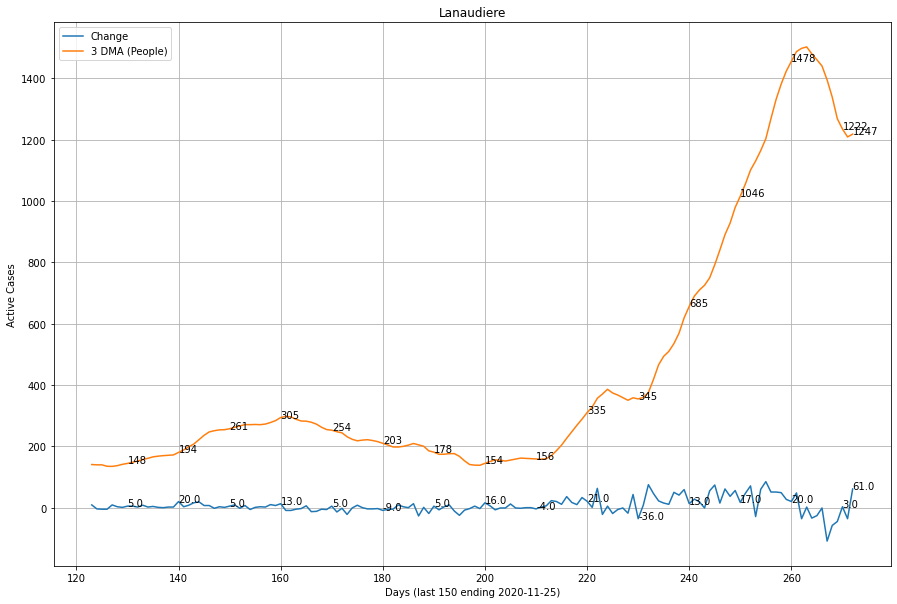

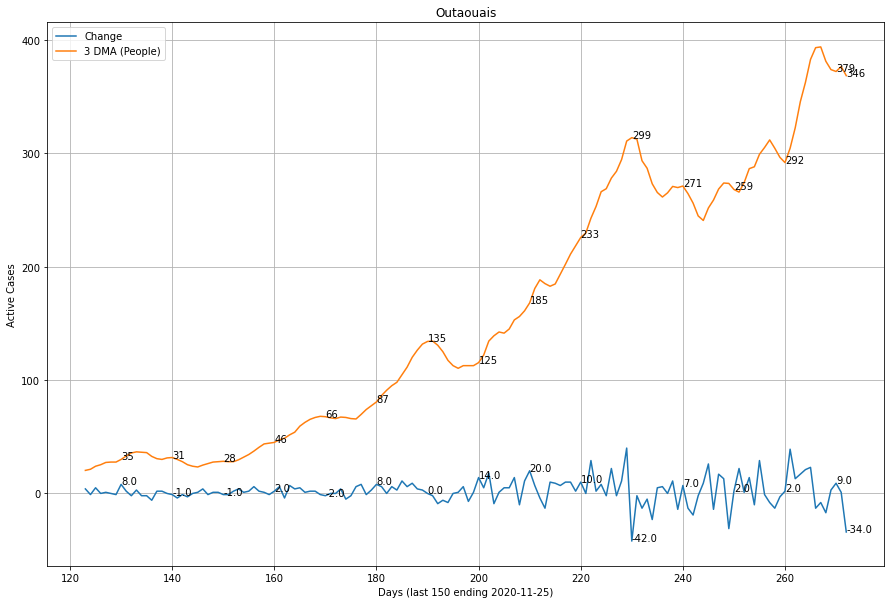

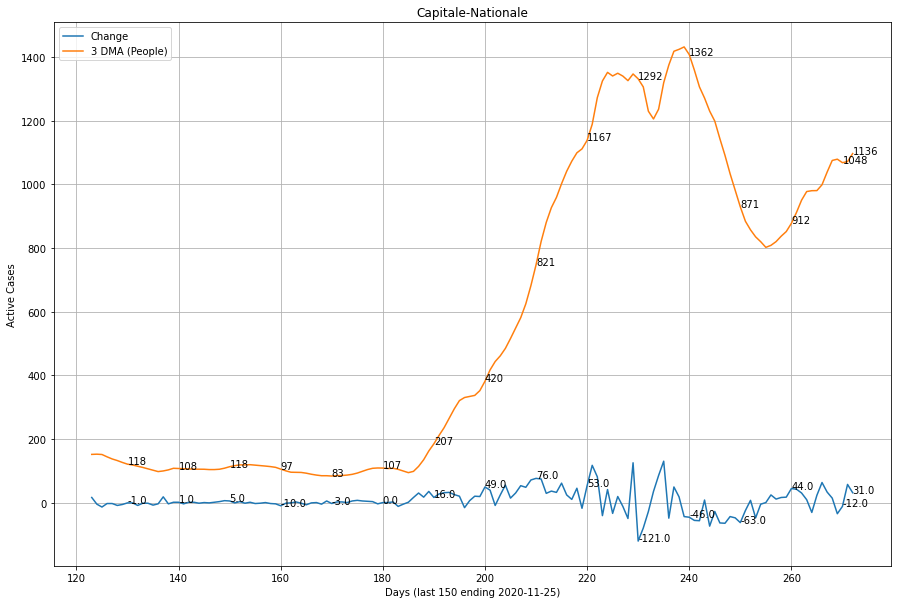

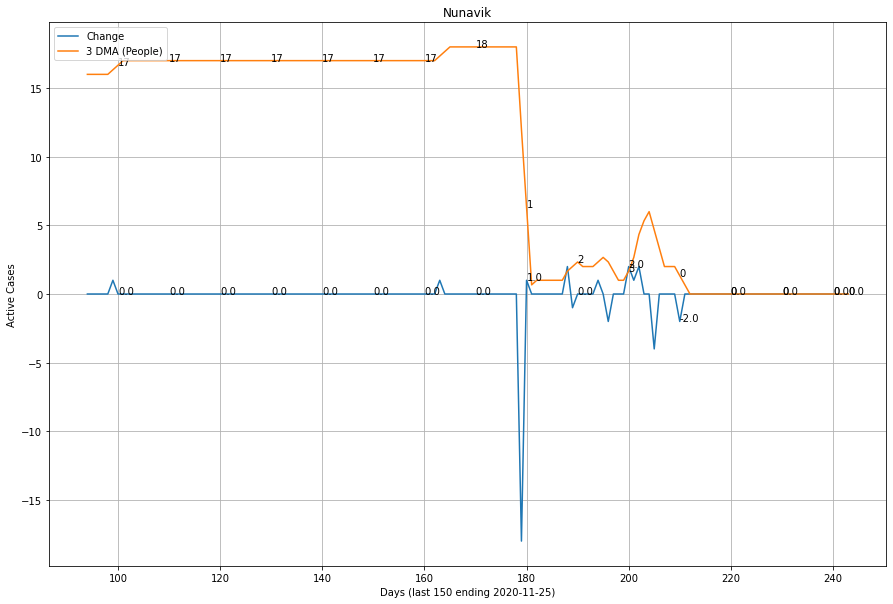

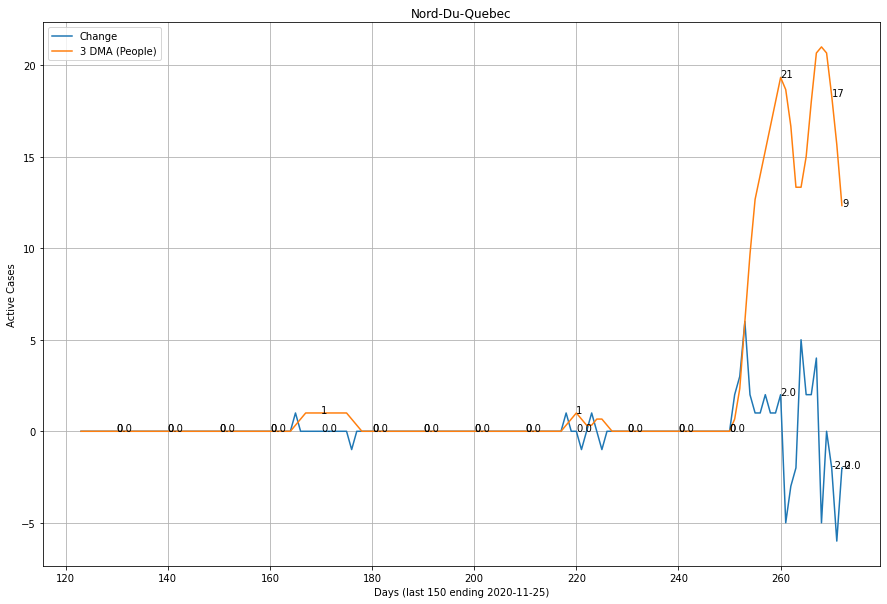

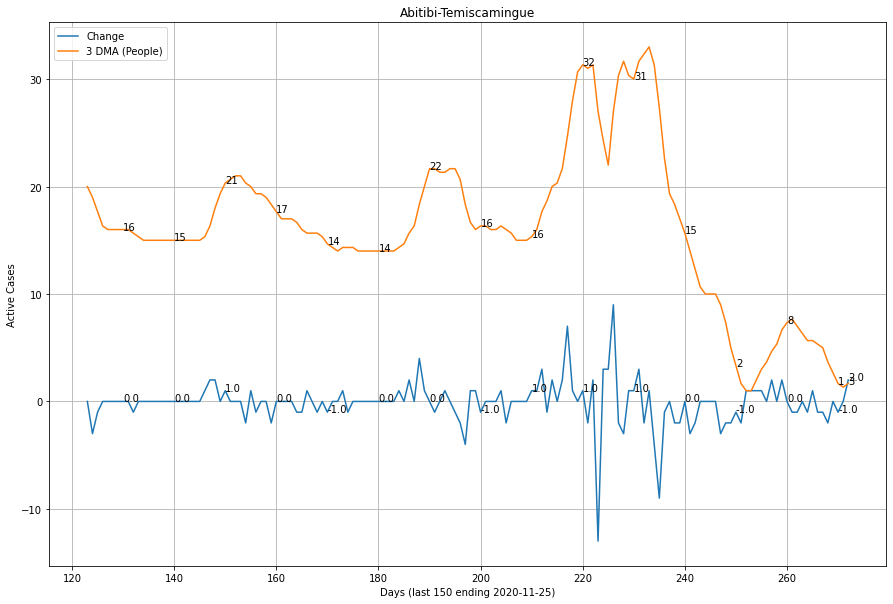

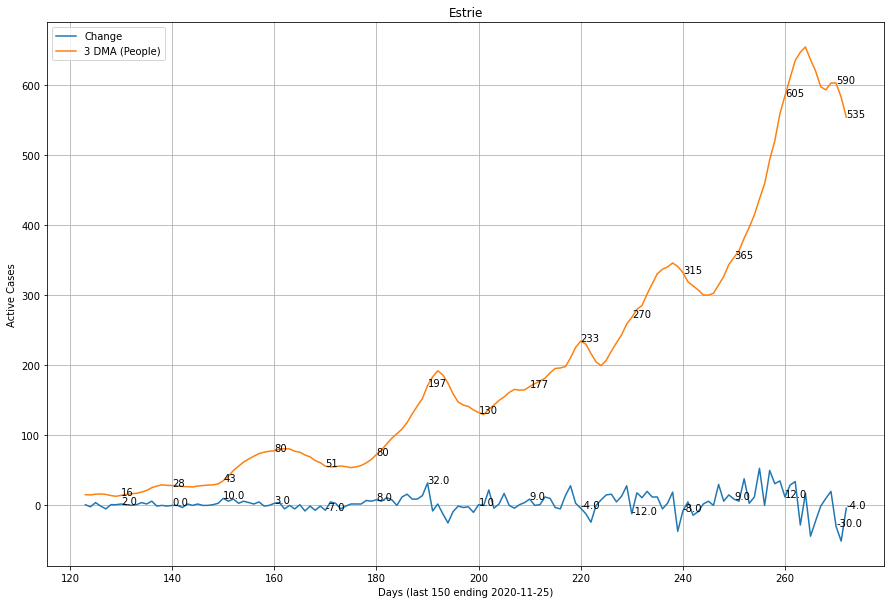

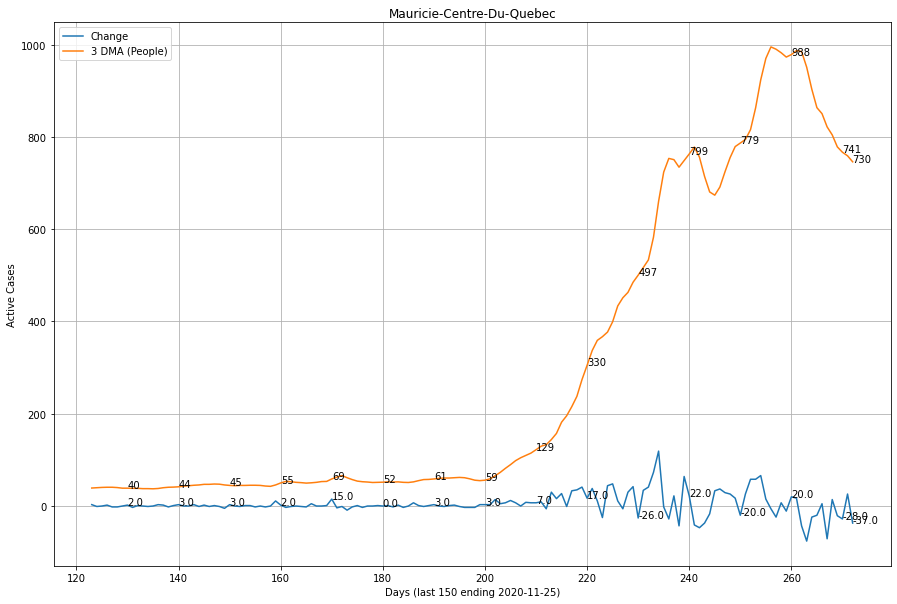

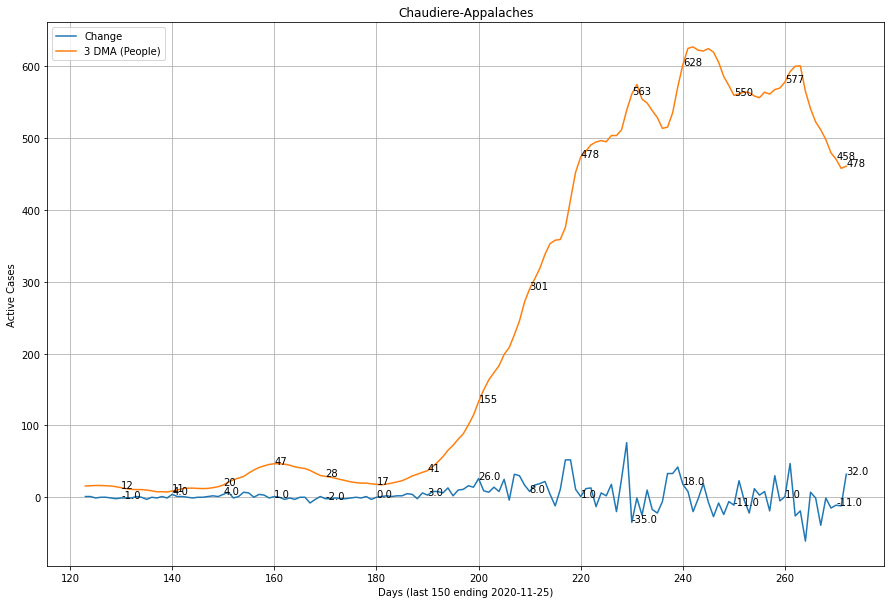

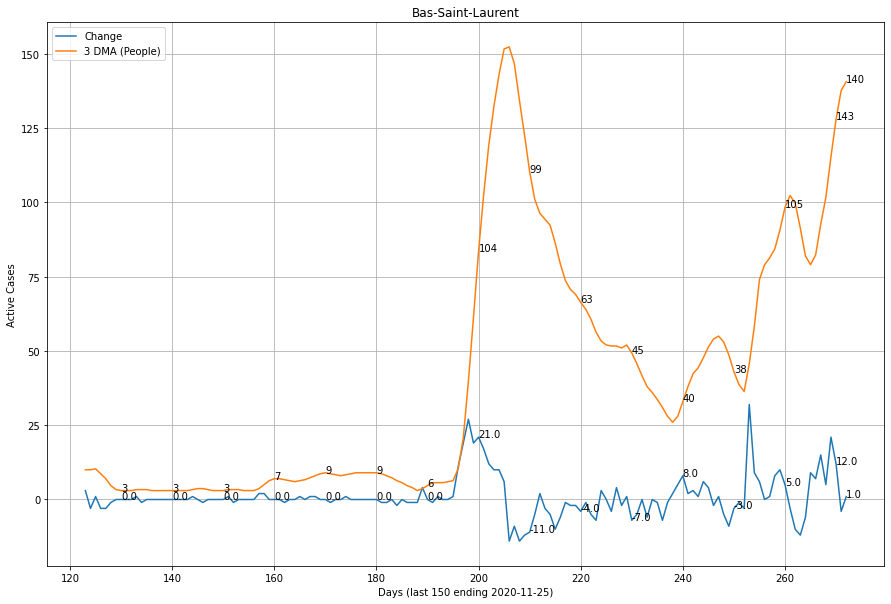

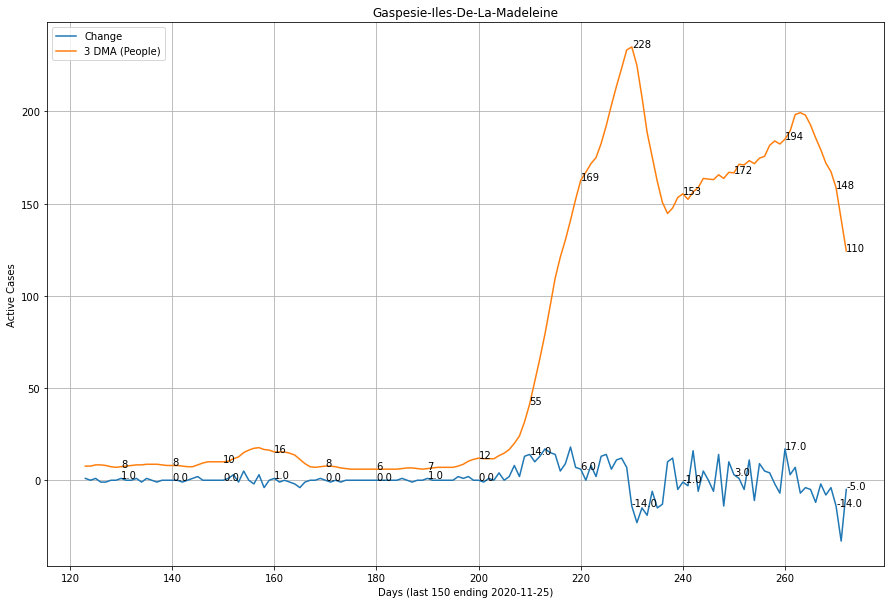

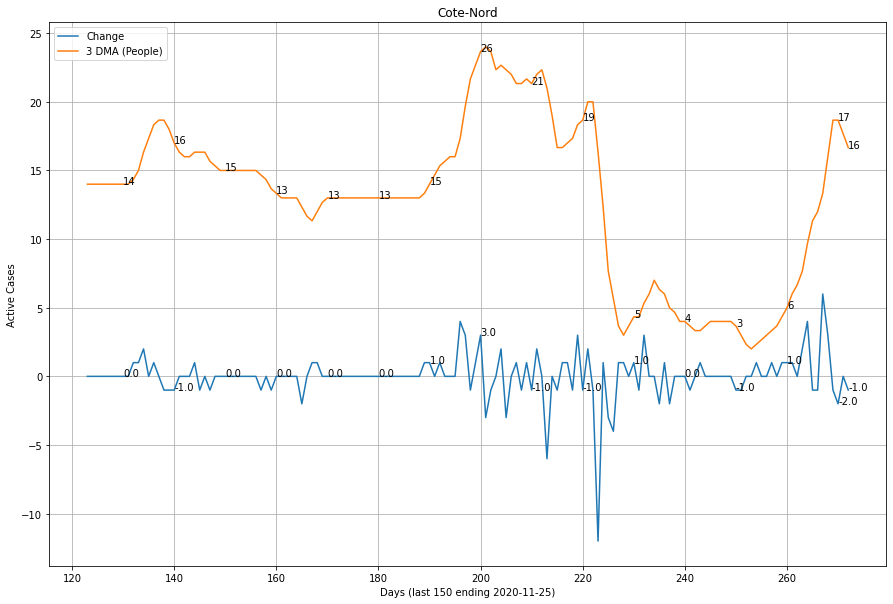

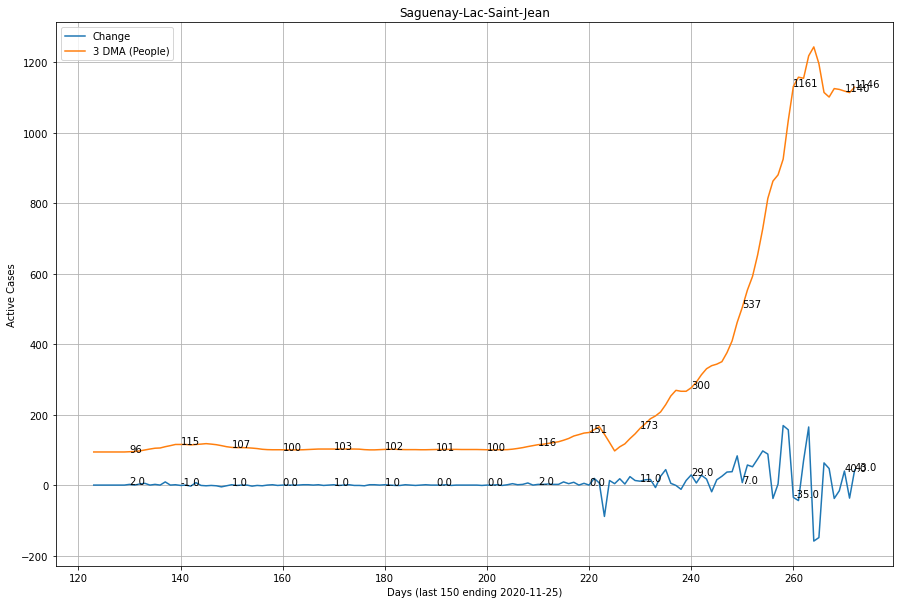

In [4]:
qcdf = get()
plot(df=qcdf, Region="Quebec", Change=True, MA=True)
plot(df=qcdf, Region="Quebec", Hospitalizations=True, ICU=True)
plot(df=qcdf, Region="Quebec", Deaths=True)
plot(df=qcdf, Region="Quebec", Tests=True)

for r in REGIONS:
    df = get(r)
    plot(df=df, Region=r, Change=True, MA=True)